# Notebook to extract the max of Specific heat

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from isingchat import style
from isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['eig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


p-1.9_nv-8_h-0_eig-2.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\finite-size\p_1.9\p-1.9_nv-8_h-0_eig-2.free-energy.h5
C_V max.: 1.0995399E-08
Temp. at C_V max.: 3.7703957


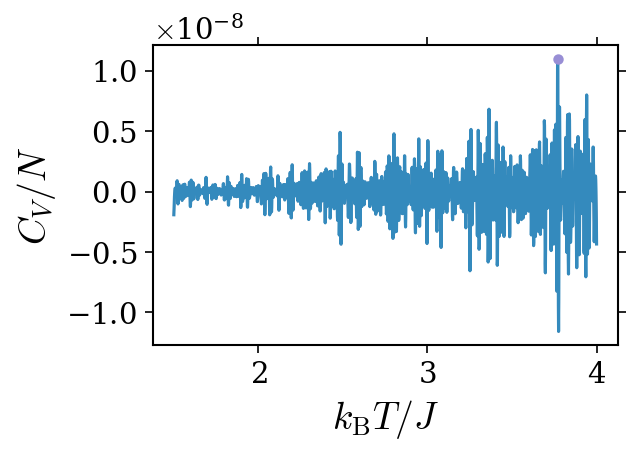

p-1.9_nv-8_h-0_eig-64.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\finite-size\p_1.9\p-1.9_nv-8_h-0_eig-64.free-energy.h5
C_V max.: 0.43067941
Temp. at C_V max.: 1.8370787


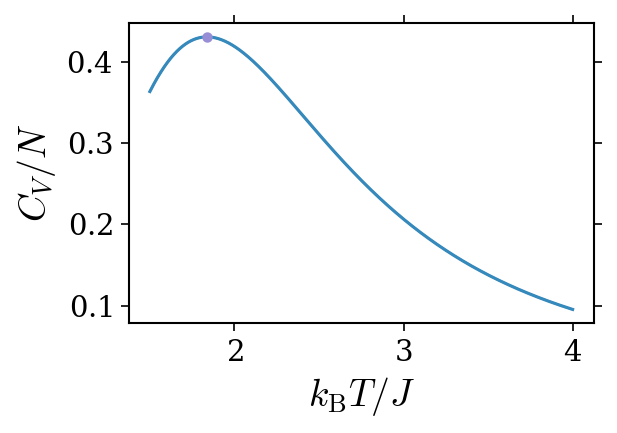

p-1.9_nv-8_h-0_eig-128.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\finite-size\p_1.9\p-1.9_nv-8_h-0_eig-128.free-energy.h5
C_V max.: 0.52375071
Temp. at C_V max.: 1.8908158


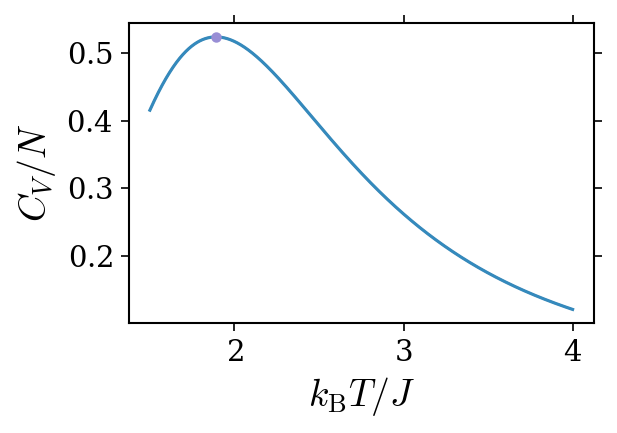

p-1.9_nv-8_h-0_eig-256.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\finite-size\p_1.9\p-1.9_nv-8_h-0_eig-256.free-energy.h5
C_V max.: 0.60808098
Temp. at C_V max.: 1.9494382


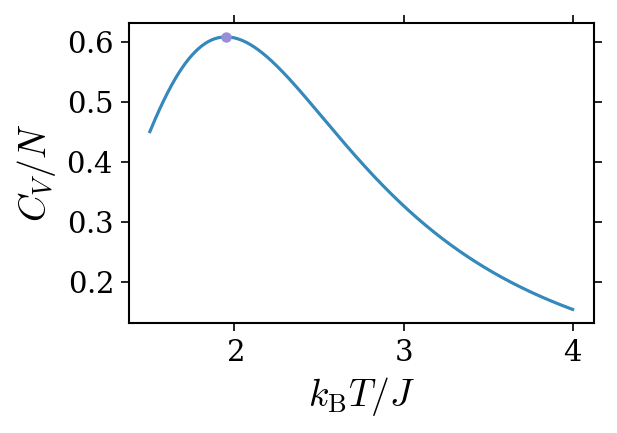

In [3]:
exp_p = 1.9
nv = 8
list_eig = [2, 64, 128, 256]
for eig in list_eig:
    data_path = Path("../../data/regular/finite-size/p_{}".format(exp_p)).resolve()
    all_files = os.listdir(data_path)
    try:
        file = 'p-{}_nv-{}_h-0_eig-{}.yml'.format(exp_p,nv,eig)
        config_file = Path(os.path.join(data_path,file)).resolve()
        energy_file = config_file.with_suffix(".free-energy.h5")
        print(file)
        print(energy_file)

        with config_file.open() as cfp:
            config_info = yaml.load(cfp)
        config_data = read_ising_config(config_info)

        with h5py.File(str(energy_file)) as h5fp:
            data_energy = h5fp["/free-energy"][()]

        temp = config_data["system"]["temperature"]
        mag_field = config_data["system"]["magnetic_field"]
        free_erg = data_energy[:, :]

        # Zero magnetic field spline
        free_erg_spl_zmf = interp.UnivariateSpline(temp,
                                                   free_erg[:, 0],
                                                   s=0, k=4)
        temp_fine = np.linspace(temp.min(), temp.max(), 2048)

        # Second derivative of the free energy.
        free_erg_der_spl_zmf = free_erg_spl_zmf.derivative(n=2)
        cv_fine = -temp_fine * free_erg_der_spl_zmf(temp_fine)
        cv_max_idx = np.argmax(cv_fine)
        temp_cv_max, cv_max = temp_fine[cv_max_idx], cv_fine[cv_max_idx]

        print(f"C_V max.: {cv_max:.8G}")
        print(f"Temp. at C_V max.: {temp_cv_max:.8G}")

        use_tex = False

        # Load the default style.
        style.use("default")
        rcParams["text.usetex"] = use_tex

        fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
        grid_spec = GridSpec(3, 1)

        # Specific heat subplot.
        ax: Axes = fig1.add_subplot(grid_spec[0, 0])

        ax.plot(temp_fine, cv_fine,)
        ax.plot(temp_fine, cv_fine, lw=1.5)
        ax.plot(temp_cv_max, cv_max, marker="o", lw=0)

        ax.set_xlabel(r"$k_\mathrm{B} T / J$")
        ax.set_ylabel(r"$C_V / N$")

        pyplot.draw()
        pyplot.show()

    except KeyError:
        print('error with this file {}'.format(file))


#     # Export to pandas 
#     print('Exporting data to {}'.format(os.path.join(data_path,'max_cv.csv')))
#     df = pd.DataFrame(all_max_cv[exp_p])
#     df.loc['inv_temp_at_max_Cv'] = 1/df.loc['temp_at_max_Cv']
#     df = df.reindex(sorted(df.columns), axis=1)
#     df.to_csv(os.path.join(data_path,'exp_p-{}_max_cv.csv'.format(exp_p)))